Überlegung: XGboost zur vorhersage einbauen
das muss aber mit den staffeln passieren, wo ich das ergebnis schon kenne um ein modell zu bauen


Found confirmed perfect match in Match Ceremony 1
New Score: 1 in Match Ceremony 1
Found confirmed perfect match in Match Ceremony 2
New Score: 1 in Match Ceremony 2
Found confirmed perfect match in Match Ceremony 3
New Score: 2 in Match Ceremony 3
Found confirmed perfect match in Match Ceremony 4
New Score: 1 in Match Ceremony 4
Found confirmed perfect match in Match Ceremony 5
New Score: 2 in Match Ceremony 5
Found confirmed perfect match in Match Ceremony 6
New Score: 2 in Match Ceremony 6
Found confirmed perfect match in Match Ceremony 7
New Score: 2 in Match Ceremony 7
Found confirmed perfect match in Match Ceremony 8
New Score: 1 in Match Ceremony 8
Found confirmed perfect match in Match Ceremony 9
New Score: 3 in Match Ceremony 9
Found confirmed perfect match in Match Ceremony 10
New Score: 4 in Match Ceremony 10


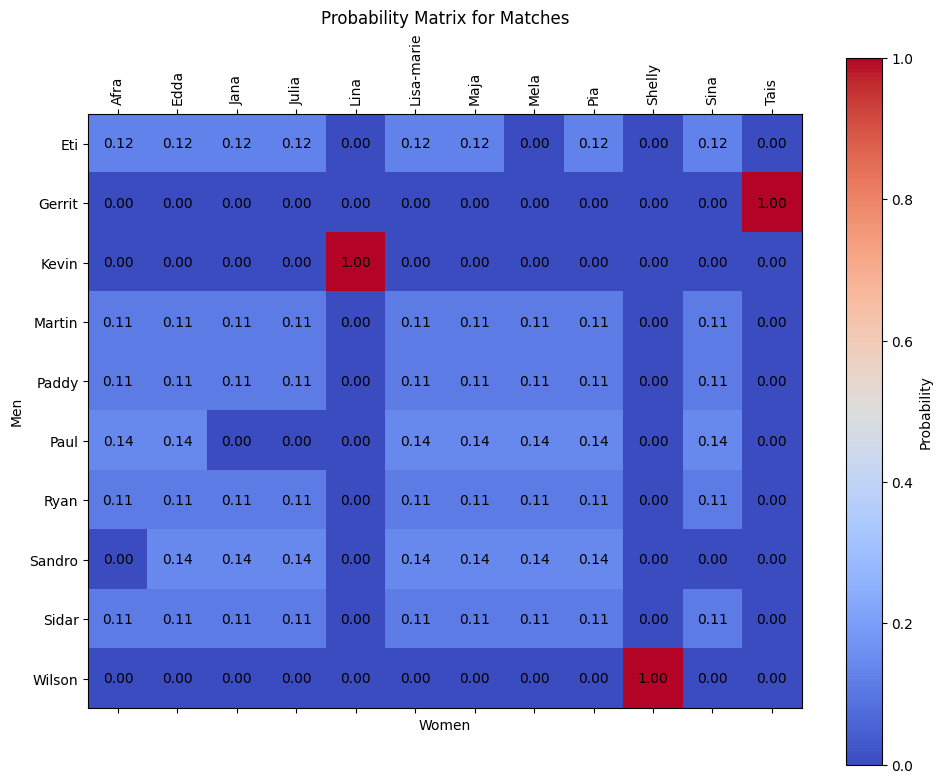

Häufigkeit der Paare:
Wilson - Shelly: 9 mal
Gerrit - Tais: 9 mal
Eti - Maja: 6 mal
Martin - Lisa-marie: 5 mal
Kevin - Lina: 5 mal
Ryan - Jana: 4 mal
Ryan - Edda: 4 mal
Paul - Sina: 4 mal
Sandro - Julia: 4 mal
Kevin - Sina: 3 mal
Sidar - Jana: 3 mal
Eti - Afra: 3 mal
Paul - Edda: 3 mal
Sidar - Afra: 3 mal
Paddy - Jana: 3 mal
Martin - Julia: 2 mal
Sandro - Edda: 2 mal
Paul - Lisa-marie: 2 mal
Sandro - Sina: 2 mal
Paddy - Lina: 2 mal
Martin - Afra: 2 mal
Sidar - Lisa-marie: 2 mal
Ryan - Lina: 1 mal
Paul - Tais: 1 mal
Gerrit - Pia: 1 mal
Eti - Lisa-marie: 1 mal
Paddy - Maja: 1 mal
Martin - Lina: 1 mal
Ryan - Pia: 1 mal
Paddy - Shelly: 1 mal
Wilson - Maja: 1 mal
Kevin - Mela: 1 mal
Paddy - Julia: 1 mal
Sandro - Pia: 1 mal
Kevin - Julia: 1 mal
Sandro - Afra: 1 mal
Sidar - Julia: 1 mal
Paddy - Edda: 1 mal
Sidar - Maja: 1 mal
Paddy - Sina: 1 mal


In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np


def load_data(filename):
    """
    Load JSON data from the given file.
    """
    with open(filename, 'r') as f:
        return json.load(f)


def initialize_probabilities(participants):
    """
    Initialize a probabilities dictionary and a fixed dictionary for all man-woman pairs.
    - probabilities[(man, woman)] starts at 0.5
    - fixed[(man, woman)] starts as False
    """
    probabilities = {}
    fixed = {}
    men = [man.lower() for man in participants['men']]
    women = [woman.lower() for woman in participants['women']]
    for man in men:
        for woman in women:
            probabilities[(man, woman)] = 0.5
            fixed[(man, woman)] = False
    return probabilities, fixed


def update_truth_booths(probabilities, fixed, truth_booths):
    """
    Update probabilities and fixed values based on truth booth results:
    - If a pair is confirmed as a match, set probability to 1.0 and exclude that man or woman from any other pair.
    - If a pair is confirmed not a match, set its probability to 0.0.
    """
    for booth in truth_booths:
        man = booth['man'].lower()
        woman = booth['woman'].lower()
        pair = (man, woman)

        if booth['is_match']:
            # Confirm this pair
            probabilities[pair] = 1.0
            fixed[pair] = True
            # Exclude this man from any other pair
            for other_pair in list(probabilities.keys()):
                if other_pair[0] == man and other_pair != pair:
                    probabilities[other_pair] = 0.0
                    fixed[other_pair] = True
            # Exclude this woman from any other pair
            for other_pair in list(probabilities.keys()):
                if other_pair[1] == woman and other_pair != pair:
                    probabilities[other_pair] = 0.0
                    fixed[other_pair] = True
        else:
            # Confirm they are not a match
            probabilities[pair] = 0.0
            fixed[pair] = True

    return probabilities, fixed


def normalize_possible_pairs(probabilities, fixed, participants):
    """
    Normalize probabilities for each man to ensure that if no pair is fixed to 1.0 for that man,
    the sum of probabilities for the remaining potential partners is 1.0.
    """
    men = [m.lower() for m in participants['men']]
    women = [w.lower() for w in participants['women']]

    for man in men:
        # Check if there's already a fixed perfect match for this man
        has_fixed_match = any(
            fixed[(man, woman)] and probabilities[(man, woman)] == 1.0
            for woman in women
        )
        if has_fixed_match:
            continue

        # If not, spread probability evenly among all remaining possible women
        possible_women = [woman for woman in women if not fixed[(man, woman)]]
        if possible_women:
            new_prob = 1.0 / len(possible_women)
            for woman in possible_women:
                probabilities[(man, woman)] = new_prob

    return probabilities


def plot_probability_matrix(probabilities, participants):
    """
    Plot a probability matrix (men vs. women) as a heatmap.
    """
    men = [m.lower() for m in participants['men']]
    women = [w.lower() for w in participants['women']]

    matrix = np.zeros((len(men), len(women)))

    for i, man in enumerate(men):
        for j, woman in enumerate(women):
            matrix[i, j] = probabilities.get((man, woman), 0)

    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(matrix, cmap='coolwarm', vmin=0, vmax=1)

    plt.xticks(ticks=np.arange(len(women)), labels=[w.capitalize() for w in women], rotation=90)
    plt.yticks(ticks=np.arange(len(men)), labels=[m.capitalize() for m in men])

    for i in range(len(men)):
        for j in range(len(women)):
            ax.text(j, i, f"{matrix[i, j]:.2f}", ha='center', va='center', color='black')

    plt.colorbar(cax, label="Probability")
    plt.xlabel("Women")
    plt.ylabel("Men")
    plt.title("Probability Matrix for Matches")
    plt.tight_layout()
    plt.show()

def count_pair_occurrences(data):
    """
    Zählt, wie oft jedes Paar in den Match Ceremonies ausgewählt wurde.
    """
    pair_counts = {}
    for episode in data['episodes']:
        if 'match_ceremony' in episode and episode['match_ceremony']:
            for p in episode['match_ceremony']['pairs']:
                # Vereinheitliche die Schreibweise
                man = p['man'].lower()
                woman = p['woman'].lower()
                key = (man, woman)
                pair_counts[key] = pair_counts.get(key, 0) + 1
    return pair_counts


def plot_pair_counts(pair_counts):
    """
    Plottet ein Balkendiagramm, das die Häufigkeit der gebildeten Paare zeigt.
    """
    pairs = list(pair_counts.keys())
    counts = [pair_counts[p] for p in pairs]
    labels = [f"{man.capitalize()} - {woman.capitalize()}" for man, woman in pairs]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(labels, counts)
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Paare")
    plt.ylabel("Häufigkeit")
    plt.title("Häufigkeit der in den Match Ceremonies gebildeten Paare")
    plt.tight_layout()
    plt.show()

def main():
    # Load data
    data = load_data("Season_5.json")
    probabilities, fixed = initialize_probabilities(data['participants'])

    # 1. Process all Truth Booth decisions first
    for episode in data['episodes']:
        if 'truth_booths' in episode and episode['truth_booths']:
            probabilities, fixed = update_truth_booths(probabilities, fixed, episode['truth_booths'])

    # 2. Check for any perfect matches identified in Truth Booths during each match ceremony
    for episode in data['episodes']:
        if 'match_ceremony' in episode and episode['match_ceremony']:
            match_ceremony = episode['match_ceremony']
            episode_num = episode['number']
            confirmed_match_count = 0

            # Check if any pairs in this ceremony are already confirmed by a Truth Booth
            for p in match_ceremony['pairs']:
                key = (p['man'].lower(), p['woman'].lower())
                if fixed.get(key, False) and probabilities.get(key, 0) == 1.0:
                    confirmed_match_count += 1

            # Adjust the ceremony's score based on confirmed perfect matches
            if confirmed_match_count > 0:
                print(f"Found confirmed perfect match in Match Ceremony {episode_num}")
                match_ceremony['score'] -= confirmed_match_count
                print(f"New Score: {match_ceremony['score']} in Match Ceremony {episode_num}")

                # If score becomes zero, it's a blackout for all unconfirmed pairs
                if match_ceremony['score'] == 0:
                    print(f"Blackout in Night {episode_num}")
                    for p in match_ceremony['pairs']:
                        key = (p['man'].lower(), p['woman'].lower())
                        if not (fixed.get(key, False) and probabilities.get(key, 0) == 1.0):
                            probabilities[key] = 0.0
                            fixed[key] = True

    # 3. Normalize probabilities across each set of potential pairs
    probabilities = normalize_possible_pairs(probabilities, fixed, data['participants'])

    # Plot the resulting probability matrix
    plot_probability_matrix(probabilities, data['participants'])

    # 5. Zähle, welche Paare am häufigsten ausgewählt wurden
    pair_counts = count_pair_occurrences(data)
    print("Häufigkeit der Paare:")
    for pair, count in sorted(pair_counts.items(), key=lambda item: item[1], reverse=True):
        print(f"{pair[0].capitalize()} - {pair[1].capitalize()}: {count} mal")



if __name__ == "__main__":
    main()
